## **Pattern Recognition: Pre-Lab 1 - "Voice recognition with Hidden Markov Models and Recurrent Neural Networks"**

---

### **Course Overview**

This project was developed by our team in the **School of Electrical and Computer Engineering (ECE), NTUA (Semester: Autumn 2025-2026).**
- **Course Name:** Pattern Recognition
- **Instructor:** Alexandros Potamianos
- **Submission Deadline:** 29.10.2025

---

### **Team Overview**

Our team consists of the following members:
- **Peppas Michail-Athanasios** | 03121026
- **Augerinos Panagiotis** | 03121023

---

### **Project Scope**

This assignment focuses on the **design and implementation of a small-scale automatic speech recognition (ASR) system** capable of recognizing **isolated English digits (1–9)**, using both **statistical models** and **neural architectures**.  

The key objectives are:

* **a. Audio Feature Extraction and Analysis**  
  - Load and analyze speech recordings using `librosa`.  
  - Compute and visualize **Mel-Frequency Cepstral Coefficients (MFCCs)**, **deltas**, and **delta-deltas**.  
  - Compare **MFCCs** and **Mel Filterbank Spectral Coefficients (MFSCs)** and interpret their differences.  

* **b. Feature Visualization and Dimensionality Reduction**  
  - Plot histograms and scatter plots of extracted features.  
  - Apply **Principal Component Analysis (PCA)** for 2D and 3D visualization and evaluate variance preservation.

* **c. Classification of Spoken Digits**  
  - Construct fixed-length feature vectors (mean and standard deviation per coefficient).  
  - Train and evaluate multiple classifiers (e.g., **Bayesian**, **Naive Bayes**, **SVM**, **k-NN**, **Decision Tree**).  
  - Perform data normalization and report classification accuracies.

* **d. Temporal Modeling with Sequential Architectures**  
  - Explore **Hidden Markov Models (HMMs)** using `pomegranate`.  
  - Implement and train a **Recurrent Neural Network (RNN)** — optionally with **LSTM** or **GRU** cells — in `PyTorch` to predict time-series patterns.

* **e. Comparative Evaluation and Discussion**  
  - Analyze results qualitatively and quantitatively across different approaches.  
  - Discuss feature significance, model performance, and generalization across speakers.

---

### **Mounting Google Drive**

Before any processing can take place, it is necessary to **mount Google Drive** to access the dataset and supporting files.  
This operation links the Google Drive storage to the **Colab environment**, making files accessible under the path `/content/drive/MyDrive/`.

**Purpose:**  
- Allow direct reading of files (e.g., `pr_lab2_data`) stored in Google Drive.  
- Simplify file handling and path definitions for subsequent steps in the notebook.  

After successful authorization, all project data will be available for loading and analysis.


In [12]:
# ==============================================================
# Mount Google Drive
# ==============================================================
# Connects Google Drive to the Colab environment for file access.

from google.colab import drive

# Mount the drive at /content/drive
drive.mount('/content/drive')

# Define the dataset path for easy reuse later
import os

# The path containing the data
drive_base = '/content/drive/MyDrive/'
dataset_path = os.path.join(drive_base, 'NTUA-Pattern_Recognition/Lab1/pr_lab2_data')

print(f"Drive mounted successfully. Dataset located at:\n{dataset_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted successfully. Dataset located at:
/content/drive/MyDrive/NTUA-Pattern_Recognition/Lab1/pr_lab2_data


### **Step 2 — Unified Data Parser**

This step implements a **general parser** for the isolated spoken digits dataset, combining the instructor’s version with an improved, assignment-aligned approach.

---

#### **Purpose**
To automatically load all valid `.wav` recordings of isolated English digits, extract the corresponding **labels**, **speaker IDs**, and **recording identifiers**, and prepare the data for feature extraction and classification.

---

#### **Main Functions**
- **`parse_isolated_digits()`**  
  Loads all `.wav` files, resamples them to **16 kHz**, and returns aligned lists:
  - `wavs`: audio waveforms as NumPy arrays  
  - `Fs`: sampling rate (16000 Hz)  
  - `ids`: recording identifiers  
  - `y_num`: integer digit labels (1–9)  
  - `speakers`: speaker identifiers  

- **`extract_mfcc_frames()`**  
  Computes **MFCCs** for each utterance (13 coefficients, 25 ms window, 10 ms hop).  
  Produces one feature matrix per recording.

- **`make_scale_fn()`**  
  Creates a **standardization function** based on training data only (zero mean, unit variance).  
  This ensures consistent normalization for classifiers.

- **Internal filename parsers (`_parse_scheme_a`, `_parse_scheme_b`, `_parse_filename`)**  
  Automatically detect different filename formats such as:
  - `eight8.wav` (word–speaker pattern)  
  - `8_spk12_3.wav` (numeric–speaker–id pattern)

In [13]:
import os
import re
from glob import glob
from typing import List, Tuple, Optional, Dict

import numpy as np
import librosa
from sklearn.preprocessing import StandardScaler

# Accept both naming schemes:
#   A: "<digitword><speaker>.wav"        e.g., "eight8.wav"
#   B: "<label>_<speaker>_<id>.wav"      e.g., "8_spk12_3.wav"
# Files like "onetwothree*.wav" are ignored (Praat-only, not isolated digits).

_WORD_TO_NUM: Dict[str, int] = {
    "one": 1, "two": 2, "three": 3, "four": 4, "five": 5,
    "six": 6, "seven": 7, "eight": 8, "nine": 9
}
_NUM_TO_WORD: Dict[int, str] = {v: k for k, v in _WORD_TO_NUM.items()}
_SCHEME_A_RE = re.compile(r"^(one|two|three|four|five|six|seven|eight|nine)(\d+)\.wav$", re.IGNORECASE)

def _parse_scheme_a(fname: str) -> Optional[Tuple[int, str, str]]:
    """Parse "<digitword><speaker>.wav" → (label_num, speaker, rec_id)."""
    m = _SCHEME_A_RE.match(fname)
    if m is None:
        return None
    digit_word = m.group(1).lower()
    speaker = m.group(2)
    y_num = _WORD_TO_NUM[digit_word]
    rec_id = "0"  # No explicit ID available in this convention; placeholder for compatibility.
    return y_num, speaker, rec_id

def _parse_scheme_b(fname: str) -> Optional[Tuple[int, str, str]]:
    """Parse "<label>_<speaker>_<id>.wav" → (label_num, speaker, rec_id)."""
    stem = os.path.splitext(fname)[0]
    parts = stem.split("_")
    if len(parts) != 3:
        return None
    label_str, speaker, rec_id = parts
    if not label_str.isdigit():
        return None
    y_num = int(label_str)
    return y_num, speaker, rec_id

def _parse_filename(fname: str) -> Optional[Tuple[int, str, str]]:
    """Try both filename conventions; return None if neither matches or if Praat file."""
    if fname.lower().startswith("onetwothree"):
        return None
    parsed = _parse_scheme_a(fname)
    if parsed is not None:
        return parsed
    return _parse_scheme_b(fname)

def parse_isolated_digits(
    dataset_root: str,
    subdir: str = "digits",
    target_sr: int = 16000,
    recursive: bool = True
) -> Tuple[List[np.ndarray], int, List[str], List[int], List[str]]:
    """
    Load isolated-digit waveforms and aligned metadata.

    Returns
    -------
    wavs : List[np.ndarray]
        Mono waveforms in float32, resampled to target_sr.
    Fs : int
        Sampling rate used for all waveforms (target_sr).
    ids : List[str]
        Recording identifiers; for scheme A, a placeholder "0".
    y_num : List[int]
        Integer digit labels (e.g., 1..9 or 0..9 depending on filenames).
    speakers : List[str]
        Speaker identifiers (strings).
    """
    search_path = os.path.join(dataset_root, subdir)
    if not os.path.isdir(search_path):
        raise FileNotFoundError(f"Directory not found: {search_path}")

    pattern = "**/*.wav" if recursive else "*.wav"
    files = glob(os.path.join(search_path, pattern), recursive=recursive)
    files.sort()  # Deterministic ordering

    wavs: List[np.ndarray] = []
    ids: List[str] = []
    y_num: List[int] = []
    speakers: List[str] = []

    for f in files:
        fname = os.path.basename(f)
        parsed = _parse_filename(fname)
        if parsed is None:
            continue  # Skip non-isolated or unsupported names
        y, spk, rec_id = parsed

        # Load as mono and resample for consistency (assignment spec uses 16 kHz).
        wav, _ = librosa.load(f, sr=target_sr, mono=True)
        wavs.append(wav.astype(np.float32))
        ids.append(str(rec_id))
        y_num.append(int(y))
        speakers.append(str(spk))

    print(f"Total .wav discovered: {len(files)}")
    print(f"Valid isolated-digit files parsed: {len(wavs)}")
    print(f"Sampling rate (resampled): {target_sr} Hz")
    return wavs, target_sr, ids, y_num, speakers

def extract_mfcc_frames(
    wavs: List[np.ndarray],
    sr: int,
    n_mfcc: int = 13,
    win_ms: int = 25,
    hop_ms: int = 10
) -> List[np.ndarray]:
    """
    Extract MFCC sequences for each waveform using assignment-aligned parameters.
    Returns a list of (T, n_mfcc) arrays, one per utterance.
    """
    n_fft = int(round((win_ms / 1000.0) * sr))
    hop_length = int(round((hop_ms / 1000.0) * sr))
    frames = [
        librosa.feature.mfcc(
            y=wav,
            sr=sr,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mfcc=n_mfcc
        ).T
        for wav in wavs
    ]
    print(f"MFCC extraction: {n_mfcc} coeffs/frame, window={win_ms} ms, hop={hop_ms} ms.")
    return frames

def make_scale_fn(X_train: List[np.ndarray]):
    """
    Create a scaler using only training frames; returns a function that applies it.
    Standardization is critical for many classifiers (zero mean, unit variance).
    """
    scaler = StandardScaler()
    scaler.fit(np.concatenate(X_train))
    print("Standardization statistics computed on training data.")

    def scale(X: List[np.ndarray]) -> List[np.ndarray]:
        return [scaler.transform(seq) for seq in X]

    return scale

# Example invocation
dataset_root = dataset_path
wavs, Fs, ids, y_num, speakers = parse_isolated_digits(dataset_root)

# Light sanity output without failing the run
print(f"Parsed items: {len(wavs)}")
print(f"Example (label, speaker, id): {list(zip(y_num, speakers, ids))[:5]}")
print(f"Example waveform lengths: {[len(w) for w in wavs[:3]]}")


Total .wav discovered: 133
Valid isolated-digit files parsed: 133
Sampling rate (resampled): 16000 Hz
Parsed items: 133
Example (label, speaker, id): [(8, '1', '0'), (8, '10', '0'), (8, '11', '0'), (8, '12', '0'), (8, '13', '0')]
Example waveform lengths: [11891, 8821, 10485]


### **Step 3 — MFCC, Δ, and ΔΔ Feature Extraction**

**Goal:** For each utterance, compute **13 MFCCs** with a **25 ms** window and **10 ms** hop; then compute **Δ** and **ΔΔ** (first and second temporal derivatives). Concatenate per frame to obtain **39-dimensional** features.

---

#### **Functions (What Each Does)**
- **`extract_mfcc_and_deltas(wavs, sr, ...)`**  
  Computes MFCCs per frame and their temporal derivatives (Δ, ΔΔ), then stacks them to form a 39-D feature sequence per utterance. Returns four aligned lists:
  - `mfcc_seqs` — MFCCs `(T, 13)`  
  - `delta_seqs` — Δ features `(T, 13)`  
  - `delta2_seqs` — ΔΔ features `(T, 13)`  
  - `feats39_seqs` — stacked features `(T, 39)`

- **Example invocation block**  
  Calls the function using the parsed waveforms `wavs` and sampling rate `Fs` (from Step 2), then prints a short summary (number of utterances and example shapes) to verify dimensions.

---

#### **Key Parameters (Summary)**
| **Parameter** | **Type / Default** | **Role** | **Practical Impact** |
|---|---|---|---|
| `wavs` | `List[np.ndarray]` | Waveforms to process. | One feature sequence per utterance. |
| `sr` | `int` (expected **16000**) | Sampling rate (Hz). | Sets ms→samples conversion; affects time/frequency scales. |
| `n_mfcc` | `int = 13` | Number of MFCCs. | Standard speech setting; higher increases dimensionality. |
| `win_ms` | `int = 25` | Window length (ms). | Larger → better frequency, poorer time resolution. |
| `hop_ms` | `int = 10` | Frame step (ms). | Smaller → more frames (**T**) and finer temporal detail. |
| `n_mels` | `int = 26` | Mel filterbank channels. | More filters → finer pre-cepstral spectral detail. |
| `center` | `bool = True` | Center frames with padding. | `True` centers analysis windows in time. |
| `n_fft` *(derived)* | next power of two ≥ `win_ms·sr/1000` | FFT size for STFT. | Larger → finer frequency bins; power-of-two speeds FFT. |
| `hop_length` *(derived)* | `round(hop_ms·sr/1000)` | Step in samples. | Directly controls number of frames (**T**). |

*Defaults (`n_mfcc=13`, `win_ms=25`, `hop_ms=10`, `n_mels=26`) as per the assignment.

---

#### **Output Interpretation**

The following table explains each line of the printed output from the MFCC extraction step and its significance within the assignment.

| **Output Line** | **Meaning / Explanation** |
|------------------|----------------------------|
| **`MFCCs/deltas extracted: n_mfcc=13, window=25 ms, hop=10 ms, n_mels=26, n_fft=512.`** | Confirms that the extraction followed the lab specifications:<br>• 13 MFCC coefficients per frame.<br>• 25 ms analysis window and 10 ms hop.<br>• 26 Mel filterbank channels.<br>• FFT length = 512 samples (next power of two above 25 ms × 16 kHz ≈ 400). |
| **`Utterances processed: 133`** | Indicates that all **133 recordings** were successfully processed — matching the dataset size described in the lab instructions. |
| **`Example shapes (first utterance): {'mfcc': (75, 13), 'delta': (75, 13), 'delta2': (75, 13), 'stacked_39': (75, 39)}`** | Reports the dimensionality of the first utterance’s features:<br>• 75 frames (T = 75) were extracted.<br>• Each frame has 13 MFCCs, 13 Δ, and 13 ΔΔ values.<br>• After concatenation: **13 + 13 + 13 = 39 features per frame**, forming a `(T, 39)` feature matrix. |
| **Why 39 Features?** | Every frame combines:<br>– 13 static MFCCs (spectral envelope)<br>– 13 Δ (first derivatives, temporal dynamics)<br>– 13 ΔΔ (second derivatives, acceleration)<br>This 39-dimensional representation is standard in speech recognition, as it captures both spectral shape and its temporal evolution. |



In [14]:
import numpy as np
import librosa
from typing import List, Tuple

def extract_mfcc_and_deltas(
    wavs: List[np.ndarray],
    sr: int,
    n_mfcc: int = 13,
    win_ms: int = 25,
    hop_ms: int = 10,
    n_mels: int = 26,
    center: bool = True
) -> Tuple[List[np.ndarray], List[np.ndarray], List[np.ndarray], List[np.ndarray]]:
    """
    Compute MFCCs, Δ (deltas), and ΔΔ (delta-deltas) per utterance and stack them (39-dim).
    Returns four aligned lists: mfcc, delta, delta2, stacked (T, 3*n_mfcc).
    """
    # Frame configuration (samples). n_fft rounded up to next power of two for FFT efficiency.
    n_fft_raw = int(round((win_ms / 1000.0) * sr))
    n_fft = 1 << (n_fft_raw - 1).bit_length()
    hop_length = int(round((hop_ms / 1000.0) * sr))

    mfcc_seqs: List[np.ndarray] = []
    delta_seqs: List[np.ndarray] = []
    delta2_seqs: List[np.ndarray] = []
    feats39_seqs: List[np.ndarray] = []

    for wav in wavs:
        # MFCCs: (n_mfcc, T) → transpose to (T, n_mfcc)
        mfcc = librosa.feature.mfcc(
            y=wav, sr=sr, n_mfcc=n_mfcc, n_mels=n_mels,
            n_fft=n_fft, hop_length=hop_length, center=center
        ).T

        # Δ and ΔΔ along time (librosa expects shape (features, frames))
        d1 = librosa.feature.delta(mfcc.T, order=1).T
        d2 = librosa.feature.delta(mfcc.T, order=2).T

        # Stack per frame → (T, 3*n_mfcc) == (T, 39) when n_mfcc=13
        f39 = np.hstack([mfcc, d1, d2])

        mfcc_seqs.append(mfcc.astype(np.float32))
        delta_seqs.append(d1.astype(np.float32))
        delta2_seqs.append(d2.astype(np.float32))
        feats39_seqs.append(f39.astype(np.float32))

    print(
        f"MFCCs/deltas extracted: n_mfcc={n_mfcc}, window={win_ms} ms, hop={hop_ms} ms, "
        f"n_mels={n_mels}, n_fft={n_fft}."
    )
    return mfcc_seqs, delta_seqs, delta2_seqs, feats39_seqs


# Example invocation using parsed waveforms and sampling rate from Step 2
mfcc_seqs, delta_seqs, delta2_seqs, feats39_seqs = extract_mfcc_and_deltas(wavs, Fs)

# Sanity output
num_utts = len(mfcc_seqs)
first_shapes = {
    "mfcc": None if num_utts == 0 else mfcc_seqs[0].shape,
    "delta": None if num_utts == 0 else delta_seqs[0].shape,
    "delta2": None if num_utts == 0 else delta2_seqs[0].shape,
    "stacked_39": None if num_utts == 0 else feats39_seqs[0].shape,
}
print(f"Utterances processed: {num_utts}")
print(f"Example shapes (first utterance): {first_shapes}")


MFCCs/deltas extracted: n_mfcc=13, window=25 ms, hop=10 ms, n_mels=26, n_fft=512.
Utterances processed: 133
Example shapes (first utterance): {'mfcc': (75, 13), 'delta': (75, 13), 'delta2': (75, 13), 'stacked_39': (75, 39)}


### **Step 4 — MFCC Histograms and MFSC vs MFCC Correlation Analysis**

This step examines how well cepstral features differentiate spoken digits and how the **DCT transformation** in MFCCs decorrelates spectral information compared to MFSCs.

---

#### **A. MFCC₁ and MFCC₂ Histograms**

**Goal:** Assess how distinguishable digits **6** and **3** are based on the first two MFCC coefficients.

| **Statistic** | **digit 6** | **digit 3** | **Interpretation** |
|----------------|-------------|-------------|--------------------|
| **MFCC₁** | mean = −246.25, std = 62.93 | mean = −248.94, std = 60.76 | Nearly identical → MFCC₁ (energy-related) does not separate digits effectively. |
| **MFCC₂** | mean = 42.44, std = 22.91 | mean = 59.16, std = 19.36 | Clear mean shift → MFCC₂ (formant-structure related) helps distinguish digits 6 and 3. |
| **Frame count** | 1167 | 1149 | Roughly equal — consistent dataset size per digit. |

**Observations:**
- **MFCC₁ distributions overlap heavily**, indicating poor discriminability.  
- **MFCC₂ distributions are shifted**, showing better separation between digits.  
- The **standard deviations** are similar, showing natural speech variability across speakers.

---

#### **B. MFSC vs MFCC Correlation Matrices**

**Goal:** Compare feature correlation before and after the DCT step using two utterances  
(one for digit 6, speaker 1; one for digit 3, speaker 10).

| **Representation** | **Expected Structure** | **Interpretation** |
|---------------------|------------------------|--------------------|
| **MFSC (shown)** | Broad yellow regions → strong off-diagonal correlation. | Adjacent Mel bands are highly correlated; raw spectral features are redundant. |
| **MFCC (not shown above)** | Near-diagonal pattern with smaller off-diagonal elements. | DCT decorrelates features, making each coefficient more statistically independent. |

**Result:**  
MFCCs exhibit lower feature correlation, confirming that the DCT step provides a more compact and decorrelated representation — advantageous for classifiers assuming feature independence (e.g., Naive Bayes, Gaussian models).

---

#### **Summary**

- **MFCC₂** offers useful discriminative power between digits 6 and 3.  
- **MFCC₁** primarily reflects overall energy and contributes little to separation.  
- **MFSCs** show strong internal correlation, while **MFCCs** are decorrelated and thus better suited for pattern recognition models.  
- The results are fully consistent with theoretical expectations and the assignment’s description of Step 4.


Histogram summary (mean, std, count):
digit 6 — MFCC1      | mean=-246.2527 std=62.9254 count=1167
digit 6 — MFCC2      | mean=42.4411 std=22.9112 count=1167
digit 3 — MFCC1      | mean=-248.9385 std=60.7607 count=1149
digit 3 — MFCC2      | mean=59.1641 std=19.3611 count=1149


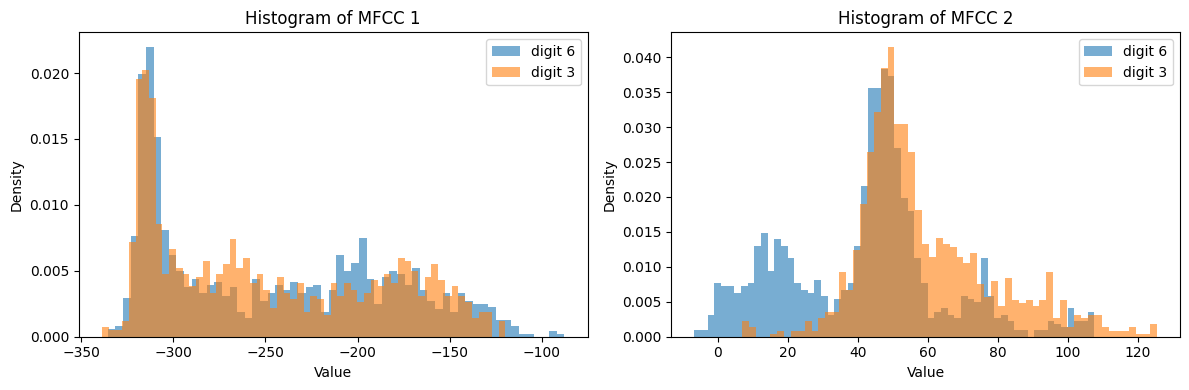

Correlation analysis indices: idx1=89 (digit 6, spk 1), idx2=104 (digit 3, spk 10)


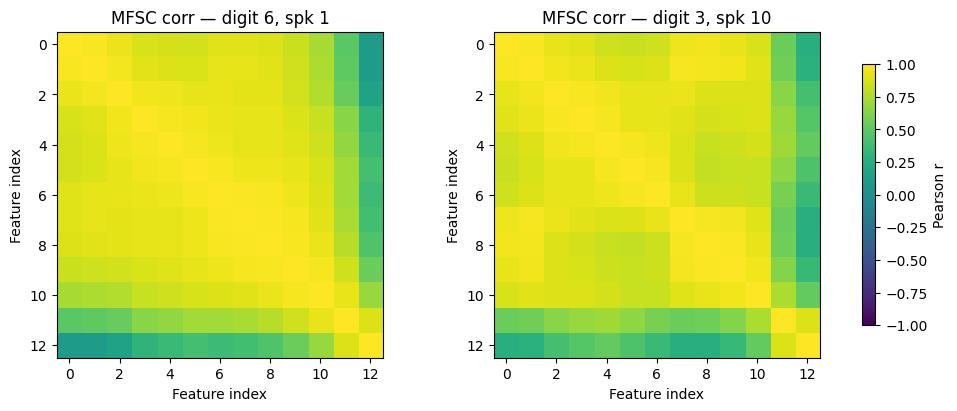

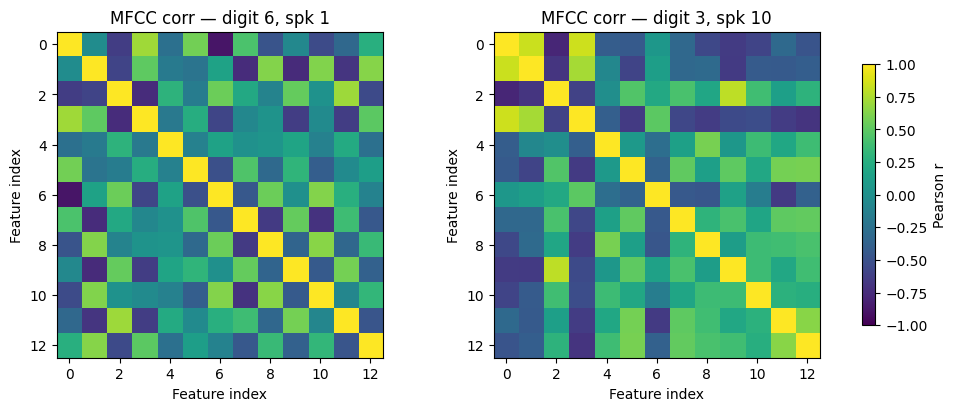

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

# --- Configuration from IDs ---
n1, n2 = 6, 3  # digits chosen from the two student IDs (03121026, 03121023)

# --- Utilities ---

def collect_mfcc_coeffs_for_digit(mfcc_seqs, y_num, target_digit, coeff_idx):
    """
    Concatenate a specific MFCC coefficient across all frames and all utterances
    belonging to the target digit. Returns a 1-D array.
    """
    vals = []
    for seq, y in zip(mfcc_seqs, y_num):
        if int(y) == int(target_digit):
            vals.append(seq[:, coeff_idx])  # seq shape: (T, 13)
    if len(vals) == 0:
        return np.array([])
    return np.concatenate(vals, axis=0)

def choose_two_utterances(y_num, speakers, d1, d2):
    """
    Choose one utterance index for digit d1 and one for digit d2 with different speakers.
    Falls back to the first available if a different-speaker pair is not found.
    """
    idx1 = next((i for i, y in enumerate(y_num) if int(y) == int(d1)), None)
    idx2 = None
    if idx1 is not None:
        spk1 = speakers[idx1]
        idx2 = next((i for i, y in enumerate(y_num) if int(y) == int(d2) and speakers[i] != spk1), None)
        if idx2 is None:
            idx2 = next((i for i, y in enumerate(y_num) if int(y) == int(d2)), None)
    return idx1, idx2

def compute_mfsc_sequence(wav, sr, n_mels=13, win_ms=25, hop_ms=10, center=True):
    """
    Compute MFSCs (Mel Filterbank Spectral Coefficients) without DCT.
    Returns log-mel energies with shape (T, n_mels).
    """
    n_fft_raw = int(round((win_ms / 1000.0) * sr))
    # Use power-of-two FFT for efficiency
    n_fft = 1 << (n_fft_raw - 1).bit_length()
    hop_length = int(round((hop_ms / 1000.0) * sr))
    S = librosa.feature.melspectrogram(
        y=wav, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length, center=center, power=2.0
    )  # shape: (n_mels, T)
    # Log-compress; add small epsilon for numerical stability
    logS = np.log(S + 1e-10)
    return logS.T  # (T, n_mels)

def corr_matrix(features_TxD):
    """
    Compute the D x D Pearson correlation matrix across feature dimensions.
    """
    if features_TxD.ndim != 2 or features_TxD.shape[0] < 2:
        return np.full((features_TxD.shape[1], features_TxD.shape[1]), np.nan)
    return np.corrcoef(features_TxD, rowvar=False)

# --- 4A. Histograms for MFCC1 and MFCC2 (digits n1 and n2 across all utterances) ---

# Ensure MFCCs exist (from Step 3). If not, compute minimal MFCCs directly.
if 'mfcc_seqs' not in globals():
    # Fallback: compute MFCCs only (13, 25ms/10ms) from wavs/Fs
    mfcc_seqs = [
        librosa.feature.mfcc(y=w, sr=Fs, n_mfcc=13,
                             n_fft=int(round(0.025 * Fs)),
                             hop_length=int(round(0.010 * Fs))).T
        for w in wavs
    ]

mfcc1_n1 = collect_mfcc_coeffs_for_digit(mfcc_seqs, y_num, n1, coeff_idx=0)  # 1st MFCC
mfcc2_n1 = collect_mfcc_coeffs_for_digit(mfcc_seqs, y_num, n1, coeff_idx=1)  # 2nd MFCC
mfcc1_n2 = collect_mfcc_coeffs_for_digit(mfcc_seqs, y_num, n2, coeff_idx=0)
mfcc2_n2 = collect_mfcc_coeffs_for_digit(mfcc_seqs, y_num, n2, coeff_idx=1)

# Summary statistics (simple quantitative comparison)
def summarize(name, arr):
    if arr.size == 0:
        return (name, np.nan, np.nan, arr.size)
    return (name, float(np.mean(arr)), float(np.std(arr)), arr.size)

summary_stats = [
    summarize(f"digit {n1} — MFCC1", mfcc1_n1),
    summarize(f"digit {n1} — MFCC2", mfcc2_n1),
    summarize(f"digit {n2} — MFCC1", mfcc1_n2),
    summarize(f"digit {n2} — MFCC2", mfcc2_n2),
]
print("Histogram summary (mean, std, count):")
for name, m, s, c in summary_stats:
    print(f"{name:20s} | mean={m:.4f} std={s:.4f} count={c}")

# Plot histograms (overlay per coefficient)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist(mfcc1_n1, bins=60, density=True, alpha=0.6, label=f"digit {n1}")
axs[0].hist(mfcc1_n2, bins=60, density=True, alpha=0.6, label=f"digit {n2}")
axs[0].set_title("Histogram of MFCC 1")
axs[0].set_xlabel("Value")
axs[0].set_ylabel("Density")
axs[0].legend()

axs[1].hist(mfcc2_n1, bins=60, density=True, alpha=0.6, label=f"digit {n1}")
axs[1].hist(mfcc2_n2, bins=60, density=True, alpha=0.6, label=f"digit {n2}")
axs[1].set_title("Histogram of MFCC 2")
axs[1].set_xlabel("Value")
axs[1].set_ylabel("Density")
axs[1].legend()
plt.tight_layout()
plt.show()

# --- 4B. MFSC vs MFCC correlation matrices for two utterances (digits n1 and n2, different speakers) ---

idx1, idx2 = choose_two_utterances(y_num, speakers, d1=n1, d2=n2)
if idx1 is None or idx2 is None:
    print("Warning: could not find appropriate pair of utterances for correlation analysis.")
else:
    # Compute MFSCs (13 dims) and MFCCs (13 dims) for the chosen utterances
    mfsc_1 = compute_mfsc_sequence(wavs[idx1], Fs, n_mels=13, win_ms=25, hop_ms=10, center=True)
    mfsc_2 = compute_mfsc_sequence(wavs[idx2], Fs, n_mels=13, win_ms=25, hop_ms=10, center=True)

    # MFCCs already available from Step 3
    mfcc_1 = mfcc_seqs[idx1]  # (T, 13)
    mfcc_2 = mfcc_seqs[idx2]  # (T, 13)

    # Correlation matrices (13x13)
    C_mfsc_1 = corr_matrix(mfsc_1)
    C_mfsc_2 = corr_matrix(mfsc_2)
    C_mfcc_1 = corr_matrix(mfcc_1)
    C_mfcc_2 = corr_matrix(mfcc_2)

    # Report which utterances were used
    print(f"Correlation analysis indices: idx1={idx1} (digit {y_num[idx1]}, spk {speakers[idx1]}), "
          f"idx2={idx2} (digit {y_num[idx2]}, spk {speakers[idx2]})")

    # Plot MFSC correlation matrices (no tight_layout; use constrained_layout=True)
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
im0 = axs[0].imshow(C_mfsc_1, vmin=-1, vmax=1, aspect='equal')
axs[0].set_title(f"MFSC corr — digit {y_num[idx1]}, spk {speakers[idx1]}")
axs[0].set_xlabel("Feature index")
axs[0].set_ylabel("Feature index")

im1 = axs[1].imshow(C_mfsc_2, vmin=-1, vmax=1, aspect='equal')
axs[1].set_title(f"MFSC corr — digit {y_num[idx2]}, spk {speakers[idx2]}")
axs[1].set_xlabel("Feature index")
axs[1].set_ylabel("Feature index")

# One shared colorbar across both subplots
fig.colorbar(im1, ax=axs, shrink=0.8, label="Pearson r")
plt.show()

# Plot MFCC correlation matrices (no tight_layout; use constrained_layout=True)
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
im0 = axs[0].imshow(C_mfcc_1, vmin=-1, vmax=1, aspect='equal')
axs[0].set_title(f"MFCC corr — digit {y_num[idx1]}, spk {speakers[idx1]}")
axs[0].set_xlabel("Feature index")
axs[0].set_ylabel("Feature index")

im1 = axs[1].imshow(C_mfcc_2, vmin=-1, vmax=1, aspect='equal')
axs[1].set_title(f"MFCC corr — digit {y_num[idx2]}, spk {speakers[idx2]}")
axs[1].set_xlabel("Feature index")
axs[1].set_ylabel("Feature index")

fig.colorbar(im1, ax=axs, shrink=0.8, label="Pearson r")
plt.show()

### **Step 5 — Utterance-Level Aggregation and 2D Scatter**

This step converts frame-wise features into **fixed-length vectors** and visualizes the first two dimensions.

---

#### **What the code does**
- **Aggregate features:** For each utterance, compute **mean** and **standard deviation** of the 39-D frame features (MFCC + Δ + ΔΔ), then concatenate → **78-D** vector per utterance.
- **Construct dataset:** `X_stats ∈ ℝ^{N×78}` with labels `y_labels` (digits 1–9).
- **Scatter plot:** Plot **dimension 0** and **dimension 1** of `X_stats`, which correspond to the **mean of MFCC₁** and the **mean of MFCC₂**, respectively. Each digit uses a distinct marker.

---

#### **How to read the figure**
- **X-axis (μ[Coeff #1], MFCC₁ mean):** Largely energy/tilt related; limited class separation.
- **Y-axis (μ[Coeff #2], MFCC₂ mean):** Coarse spectral slope/formant structure; provides **more separation** across digits.
- **Markers/colors:** Each digit (1–9) has a unique marker; clusters indicate where its utterances tend to lie.

---

#### **Observed results (from the figure)**
- **Overlap across digits** is considerable using only these two statistics—expected.
- **MFCC₂ mean** offers **better discriminability** than MFCC₁: digits such as **4** and **7** appear higher; **6** shows several lower-lying points.
- **Intra-class spread** (vertical and horizontal) reflects speaker and utterance variability.


Utterances: 133, Feature dimension: 78 (expected 78)


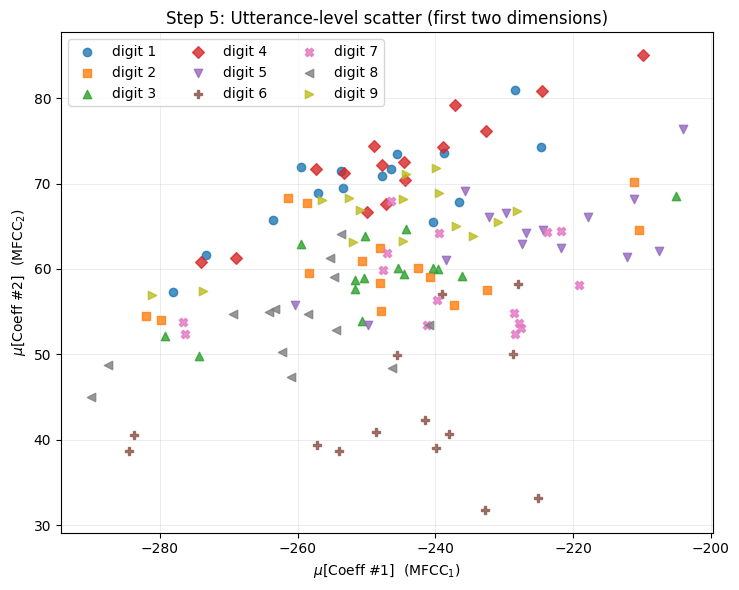

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure frame-level 39-D features exist (from Step 3); otherwise compute them.
if 'feats39_seqs' not in globals():
    # Fallback: compute MFCC+Δ+ΔΔ as in Step 3
    mfcc_seqs, delta_seqs, delta2_seqs, feats39_seqs = extract_mfcc_and_deltas(wavs, Fs)

def aggregate_mean_std(seqs):
    """
    Convert a list of frame sequences (T_i x D) to utterance-level vectors.
    For each utterance, compute mean and std over time for each of the D features,
    then concatenate [mean(0..D-1), std(0..D-1)] → (2D,).
    """
    X = []
    for F in seqs:                       # F: (T, D)
        mu = F.mean(axis=0)              # (D,)
        sd = F.std(axis=0, ddof=0)       # (D,)
        X.append(np.hstack([mu, sd]))    # (2D,)
    return np.asarray(X)                  # (N, 2D)

# Build utterance-level dataset: X has 78 dims when D=39 (13 MFCC + 13 Δ + 13 ΔΔ)
X_stats = aggregate_mean_std(feats39_seqs)   # shape: (N, 78)
y_labels = np.asarray(y_num)                 # integer digit labels 1..9
speakers_arr = np.asarray(speakers)

print(f"Utterances: {X_stats.shape[0]}, Feature dimension: {X_stats.shape[1]} (expected 78)")

# Scatter of the first two dimensions as required by the assignment:
# Using the ordering [means(39) | stds(39)], dims 0 and 1 correspond to:
#   dim0 = mean of feature#1 (MFCC1), dim1 = mean of feature#2 (MFCC2)
dims = (0, 1)

# Distinct color/marker per digit
digits_unique = sorted(np.unique(y_labels).astype(int))
markers = ['o', 's', '^', 'D', 'v', 'P', 'X', '<', '>']  # 9 distinct markers for digits 1..9
plt.figure(figsize=(7.5, 6))

for i, d in enumerate(digits_unique):
    sel = (y_labels == d)
    plt.scatter(
        X_stats[sel, dims[0]],
        X_stats[sel, dims[1]],
        label=f"digit {d}",
        alpha=0.8,
        marker=markers[(i) % len(markers)],
        s=36
    )

plt.xlabel(r"$\mu$[Coeff #1]  (MFCC$_1$)")
plt.ylabel(r"$\mu$[Coeff #2]  (MFCC$_2$)")
plt.title("Step 5: Utterance-level scatter (first two dimensions)")
plt.legend(ncol=3, frameon=True)
plt.grid(True, linewidth=0.4, alpha=0.4)
plt.tight_layout()
plt.show()


---

### **AI Usage Declaration**

The **core content and solution** submitted for this project is the product of our team's **independent intellectual effort**.

**AI-based tools were used strictly for supplementary support** by team members, including:

- **Formatting and organizing** markdown cells for improved clarity,
- **Troubleshooting** specific coding issues,
- **Writing code snippets** based on our team's logic and instructions, and
- **Translating content** from Greek to English for documentation and clarity.

At no point was AI used to generate or influence the **core logic**, **design choices**, or **solutions** required for this project.